# Introduction

This is sample code for semantic segmentaion with U-Net and PyTorch. You can also see U-Net with Keras at [Aerial Semantic Segmentation (U-Net, Keras)](https://www.kaggle.com/code/gokifujiya/aerial-semantic-segmentation-u-net-keras/notebook) and SegNet with Keras at [Aerial Semantic Segmentation (SegNet, Keras)](https://www.kaggle.com/code/gokifujiya/aerial-semantic-segmentation-segnet-keras/notebook).

# Install Packages and Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.__version__
import PIL
PIL.__version__
from PIL import Image
from glob import glob
import os
os.getcwd()
import cv2

import torch
torch.__version__
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
torchvision.__version__
from torchvision import transforms

In [2]:
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=eca4fc2e88c9376c160fde01f6ec2c28d9154e7e8c45c69b148aef7a5c8a9ba9
  Stored in directory: /root/.cache/pip/wheels/96/3f/5f/13976445f67f3b4e77b054e65f7f4c39016e92e8358fe088db
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=5a5b95356b739f76c7846a88d64a51e576706702955f89494f9d1bef0132e9e7
  Stored in directory: /root/.cache/pip/wheels/4f/89/a3/5cf59e30a8a75c917c313f14da0f6209be2d147e3160b985d6
Successfully built efficientnet-pytorch pretrainedmodels


# Read CSV File

In [3]:
df = pd.read_csv('/kaggle/input/semantic-drone-dataset/class_dict_seg.csv')
df.head()

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87


In [4]:
df.name

0       unlabeled
1      paved-area
2            dirt
3           grass
4          gravel
5           water
6           rocks
7            pool
8      vegetation
9            roof
10           wall
11         window
12           door
13          fence
14     fence-pole
15         person
16            dog
17            car
18        bicycle
19           tree
20      bald-tree
21      ar-marker
22       obstacle
23    conflicting
Name: name, dtype: object

In [5]:
class_list = df.name.values.tolist()
print(class_list)
len(class_list)

['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']


24

# Sample Images

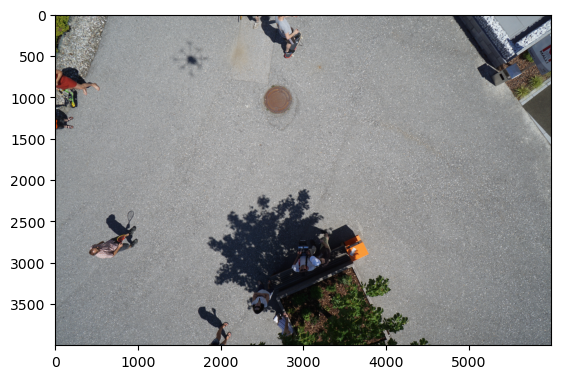

In [6]:
# original image
image = Image.open('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg')
image = np.array(image)
plt.imshow(image)

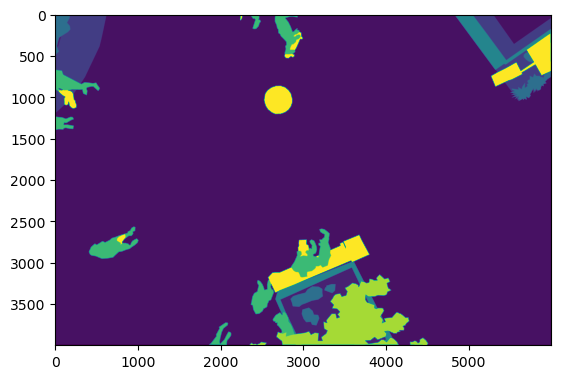

In [7]:
# label image
label = Image.open('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png')
label = np.array(label)
plt.imshow(label)

In [8]:
image.shape, label.shape

((4000, 6000, 3), (4000, 6000))

In [9]:
image.min(), image.max()

(0, 255)

In [10]:
label.min(), label.max()

(0, 22)

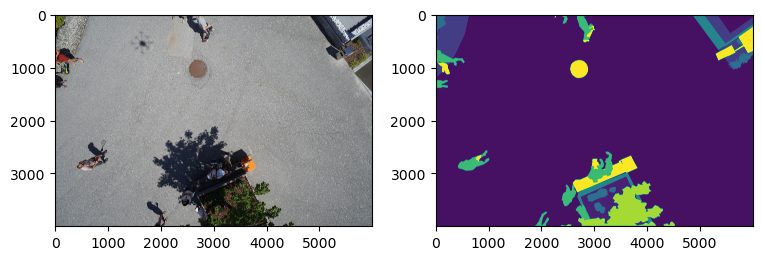

In [11]:
plt.figure(figsize = (9, 4))

plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(label)

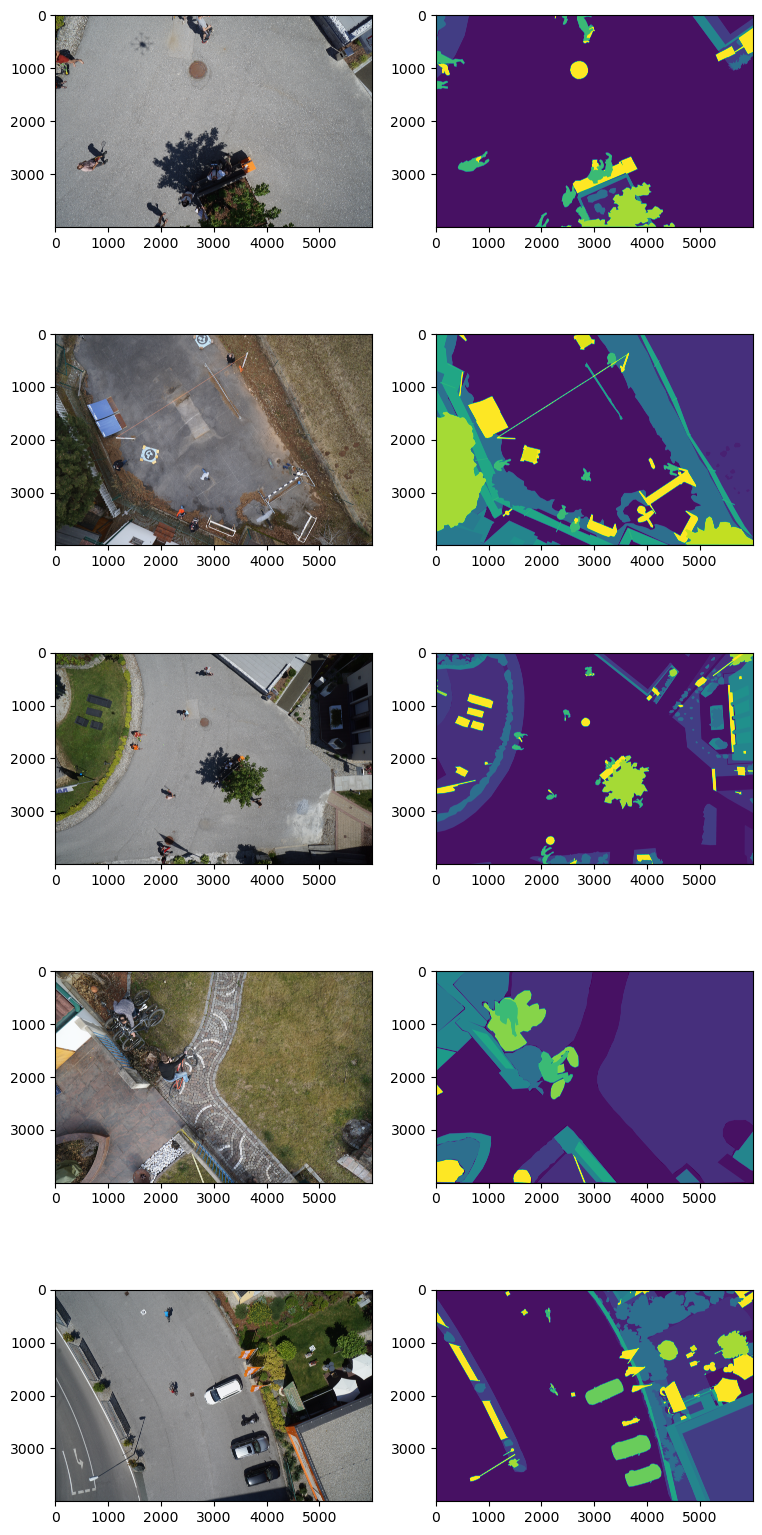

In [12]:
# 5 original and label images
n_max_imgs = 5

plt.figure(figsize = (9, 20))
for n in range(n_max_imgs):

    image = Image.open(f'/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/00{n}.jpg')
    image = np.array(image)

    label = Image.open(f'/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/00{n}.png')
    label = np.array(label)

    plt.subplot(n_max_imgs, 2, 2 * n + 1)
    plt.imshow(image)

    plt.subplot(n_max_imgs, 2, 2 * n + 2)
    plt.imshow(label)

In [13]:
images = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/*.jpg'))
#print(images)

In [14]:
len(images)

400

In [15]:
labels = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/*.png'))
#print(labels)

In [16]:
len(labels)

400

# Creation of Dataset and Data Loader

In [17]:
'''
class Dataset(torch.utils.data.Dataset):

    def __init__(self):
        self.images = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/*.jpg'))
        self.labels = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/*.png'))
        self.transform = transforms.Compose([ transforms.ToTensor() ])


    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        image = self.transform(image)

        label_path = self.labels[idx]
        label = Image.open(label_path)
        label = np.array(label)
        label = torch.tensor(label, dtype = torch.int64)
        return image, label


    def __len__(self):
        return len(self.images)
'''

"\nclass Dataset(torch.utils.data.Dataset):\n\n    def __init__(self):\n        self.images = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/*.jpg'))\n        self.labels = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/*.png'))\n        self.transform = transforms.Compose([ transforms.ToTensor() ])\n\n\n    def __getitem__(self, idx):\n        image_path = self.images[idx]\n        image = Image.open(image_path)\n        image = self.transform(image)\n\n        label_path = self.labels[idx]\n        label = Image.open(label_path)\n        label = np.array(label)\n        label = torch.tensor(label, dtype = torch.int64)\n        return image, label\n\n\n    def __len__(self):\n        return len(self.images)\n"

In [18]:
class Dataset(torch.utils.data.Dataset):
    
      def __init__(
          self,
          transform = None,
          classes = None,
          augmentation = None
          ):
        self.imgpath_list = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/*.jpg'))
        self.labelpath_list = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/*.png'))

      def __getitem__(self, i):
                
        imgpath = self.imgpath_list[i]
        img = cv2.imread(imgpath)
        img = cv2.resize(img, dsize = (256, 256))
        img = img / 255
        img = torch.from_numpy(img.astype(np.float32)).clone()
        img = img.permute(2, 0, 1)

        labelpath = self.labelpath_list[i]
        label = Image.open(labelpath)
        label = np.asarray(label)
        label = cv2.resize(label, dsize = (256, 256))
        label = torch.from_numpy(label.astype(np.float32)).clone()
        label = torch.nn.functional.one_hot(label.long(), num_classes = len(class_list))
        label = label.to(torch.float32)
        label = label.permute(2, 0, 1)

        data = {"img": img, "label": label}
        return data

      def __len__(self):
            return len(self.imgpath_list)

In [19]:
dataset = Dataset()

In [20]:
len(dataset)

400

In [21]:
train, val, test = torch.utils.data.random_split(dataset = dataset, lengths = [320, 40, 40], generator = torch.Generator().manual_seed(42))

len(train), len(val), len(test)

(320, 40, 40)

In [22]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle = True, drop_last = True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

# Creation of Model

In [23]:
class TwoConvBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size = 3, padding = "same")
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.rl = nn.ReLU()
        self.conv2 = nn.Conv2d(middle_channels, out_channels, kernel_size = 3, padding = "same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rl(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rl(x)
        return x

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding = "same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x

class UNet_2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.TCB1 = TwoConvBlock(3, 64, 64)
        self.TCB2 = TwoConvBlock(64, 128, 128)
        self.TCB3 = TwoConvBlock(128, 256, 256)
        self.TCB4 = TwoConvBlock(256, 512, 512)
        self.TCB5 = TwoConvBlock(512, 1024, 1024)
        self.TCB6 = TwoConvBlock(1024, 512, 512)
        self.TCB7 = TwoConvBlock(512, 256, 256)
        self.TCB8 = TwoConvBlock(256, 128, 128)
        self.TCB9 = TwoConvBlock(128, 64, 64)
        self.maxpool = nn.MaxPool2d(2, stride = 2)
        
        self.UC1 = UpConv(1024, 512) 
        self.UC2 = UpConv(512, 256) 
        self.UC3 = UpConv(256, 128) 
        self.UC4= UpConv(128, 64)

        self.conv1 = nn.Conv2d(64, 24, kernel_size = 1)
        self.soft = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.TCB1(x)
        x1 = x
        x = self.maxpool(x)

        x = self.TCB2(x)
        x2 = x
        x = self.maxpool(x)

        x = self.TCB3(x)
        x3 = x
        x = self.maxpool(x)

        x = self.TCB4(x)
        x4 = x
        x = self.maxpool(x)

        x = self.TCB5(x)

        x = self.UC1(x)
        x = torch.cat([x4, x], dim = 1)
        x = self.TCB6(x)

        x = self.UC2(x)
        x = torch.cat([x3, x], dim = 1)
        x = self.TCB7(x)

        x = self.UC3(x)
        x = torch.cat([x2, x], dim = 1)
        x = self.TCB8(x)

        x = self.UC4(x)
        x = torch.cat([x1, x], dim = 1)
        x = self.TCB9(x)

        x = self.conv1(x)

        return x

# Training and Validation

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = UNet_2D().to(device)
optimizer = optim.Adam(unet.parameters(), lr = 0.001)

In [25]:
TverskyLoss = smp.losses.TverskyLoss(mode = 'multilabel', log_loss = False)
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
def criterion(pred,target):
    return 0.5 * BCELoss(pred, target) + 0.5 * TverskyLoss(pred, target)

In [26]:
history = {"train_loss": []}
n = 0
m = 0
val_loss_min = np.Inf

for epoch in range(15):
  train_loss = 0
  val_loss = 0

  unet.train()
  for i, data in enumerate(train_loader):
    inputs, labels = data["img"].to(device), data["label"].to(device)
    optimizer.zero_grad()
    outputs = unet(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    history["train_loss"].append(loss.item())
    n += 1
    if i % ((len(train) // batch_size) // 10) == (len(train) // batch_size) // 10 - 1:
      print(f"epoch:{epoch + 1}  index:{i + 1}  train_loss:{train_loss / n:.5f}")
      n = 0
      train_loss = 0
      train_acc = 0


  unet.eval()
  with torch.no_grad():
    for i, data in enumerate(val_loader):
      inputs, labels = data["img"].to(device), data["label"].to(device)
      outputs = unet(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      m += 1
      if i % (len(val) // batch_size) == len(val) // batch_size - 1:
        print(f"epoch:{epoch + 1}  index:{i + 1}  val_loss:{val_loss / m:.5f}")
        m = 0
        val_loss = 0
        val_acc = 0
    if val_loss < val_loss_min:
        torch.save(unet.state_dict(), 'semantic_segmentation.pt')
        print('Detected network improvement, saving current model')
        
print("finish training")

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py:460: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/Convolution.cpp:895.)
  self.padding, self.dilation, self.groups)


epoch:1  index:8  train_loss:0.76772
epoch:1  index:16  train_loss:0.71273
epoch:1  index:24  train_loss:0.67076
epoch:1  index:32  train_loss:0.63302
epoch:1  index:40  train_loss:0.60574
epoch:1  index:48  train_loss:0.58098
epoch:1  index:56  train_loss:0.56126
epoch:1  index:64  train_loss:0.54421
epoch:1  index:72  train_loss:0.53209
epoch:1  index:80  train_loss:0.51995
epoch:1  index:10  val_loss:0.51350
Detected network improvement, saving current model
epoch:2  index:8  train_loss:0.51713
epoch:2  index:16  train_loss:0.49611
epoch:2  index:24  train_loss:0.49678
epoch:2  index:32  train_loss:0.49844
epoch:2  index:40  train_loss:0.49826
epoch:2  index:48  train_loss:0.49039
epoch:2  index:56  train_loss:0.49055
epoch:2  index:64  train_loss:0.47696
epoch:2  index:72  train_loss:0.47661
epoch:2  index:80  train_loss:0.47785
epoch:2  index:10  val_loss:0.47989
Detected network improvement, saving current model
epoch:3  index:8  train_loss:0.47112
epoch:3  index:16  train_loss:0

Text(0, 0.5, 'loss')

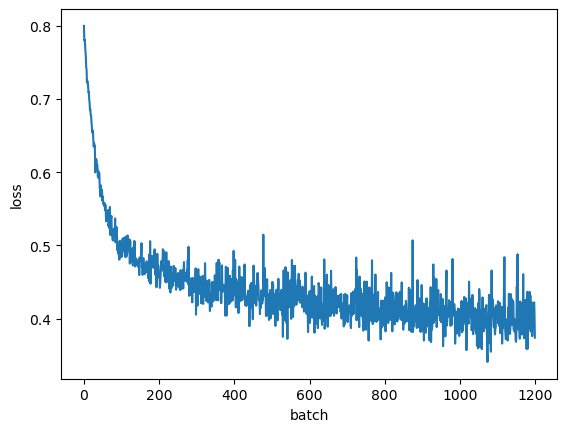

In [27]:
plt.plot(history["train_loss"])
plt.xlabel('batch')
plt.ylabel('loss')

# Load the Best Model

In [28]:
# importing trained network with the best loss of validation
unet.load_state_dict(torch.load('semantic_segmentation.pt'))

<All keys matched successfully>

# Prediction and Comparison with the Truth Data

In [29]:
model = UNet_2D()
model.load_state_dict(torch.load("semantic_segmentation.pt"))
model.eval()
with torch.no_grad():
  data = next(iter(test_loader))
  inputs, labels = data["img"], data["label"]
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  print("loss: ",loss.item())

sigmoid = nn.Sigmoid()
outputs = sigmoid(outputs)
pred = torch.argmax(outputs, axis = 1)
pred = torch.nn.functional.one_hot(pred.long(), num_classes = len(class_list)).to(torch.float32)

loss:  0.4145127534866333


(-0.5, 255.5, 255.5, -0.5)

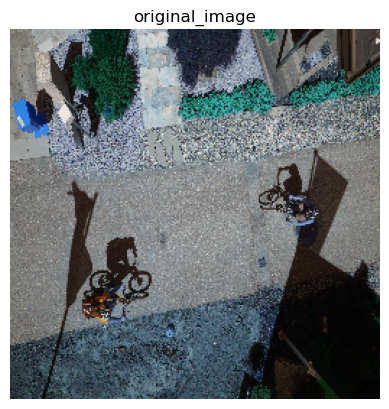

In [30]:
plt.figure()
plt.imshow(data["img"][0, :, :, :].permute(1, 2, 0))
plt.title("original_image")
plt.axis("off")

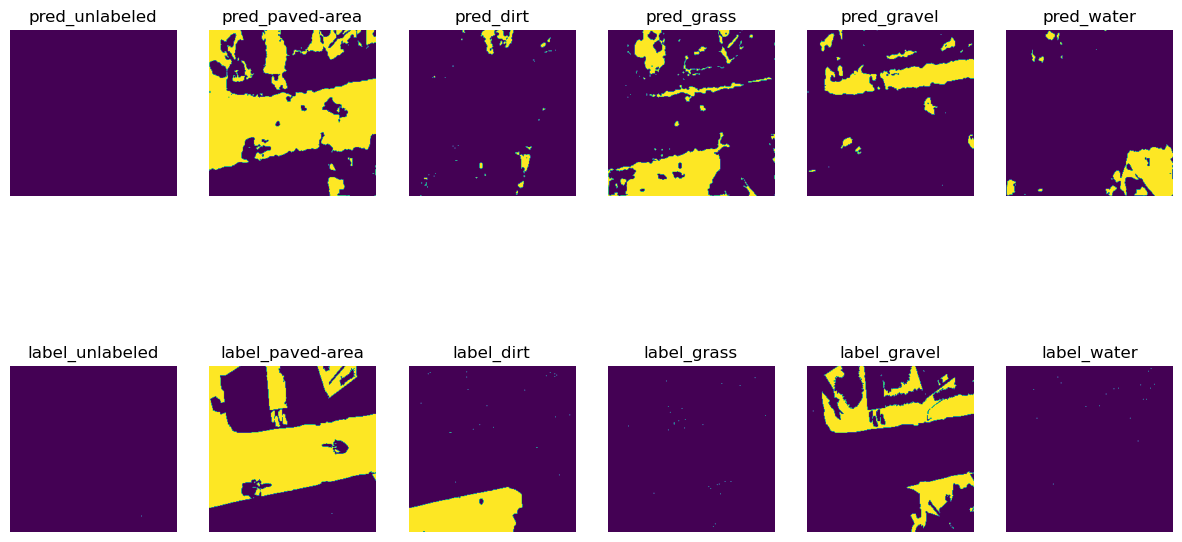

In [31]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for i in range(2):
    for j, cl in enumerate(classes):
        if i == 0 and j < 6:
            ax[i, j].imshow(pred[0, :, :, j])
            ax[i, j].set_title(f"pred_{cl}")
            ax[i, j].axis("off")
        elif j < 6:
            ax[i, j].imshow(data["label"][0, j, :, :])    
            ax[i, j].set_title(f"label_{cl}")
            ax[i, j].axis("off")

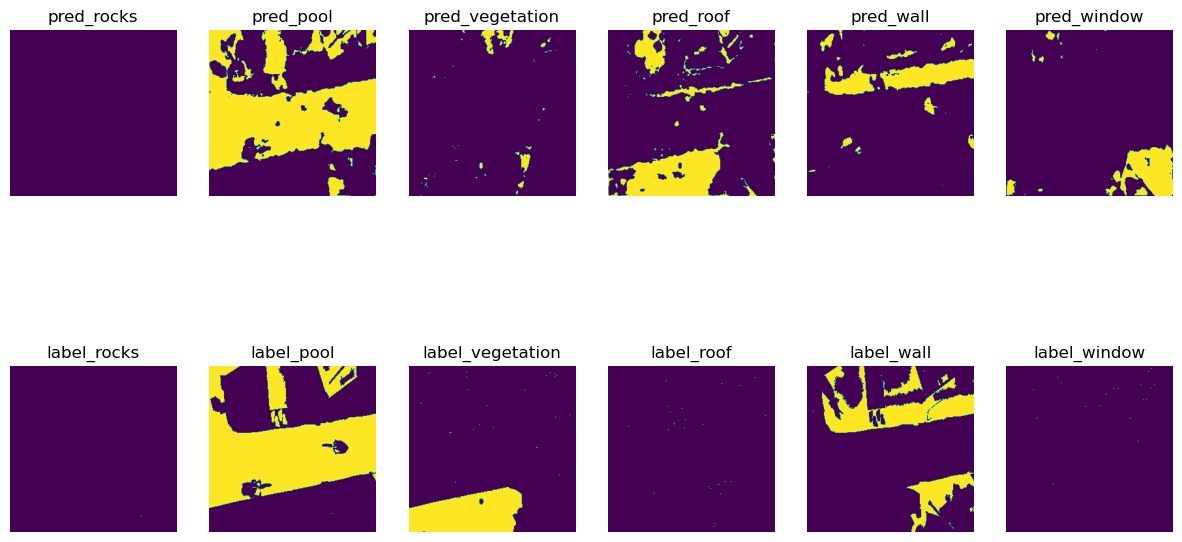

In [32]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for i in range(2):
    for j, cl in enumerate(classes[6:12]):
        if i == 0 and j < 6:
            ax[i, j].imshow(pred[0, :, :, j])
            ax[i, j].set_title(f"pred_{cl}")
            ax[i, j].axis("off")
        elif j < 6:
            ax[i, j].imshow(data["label"][0, j, :, :])    
            ax[i, j].set_title(f"label_{cl}")
            ax[i, j].axis("off")

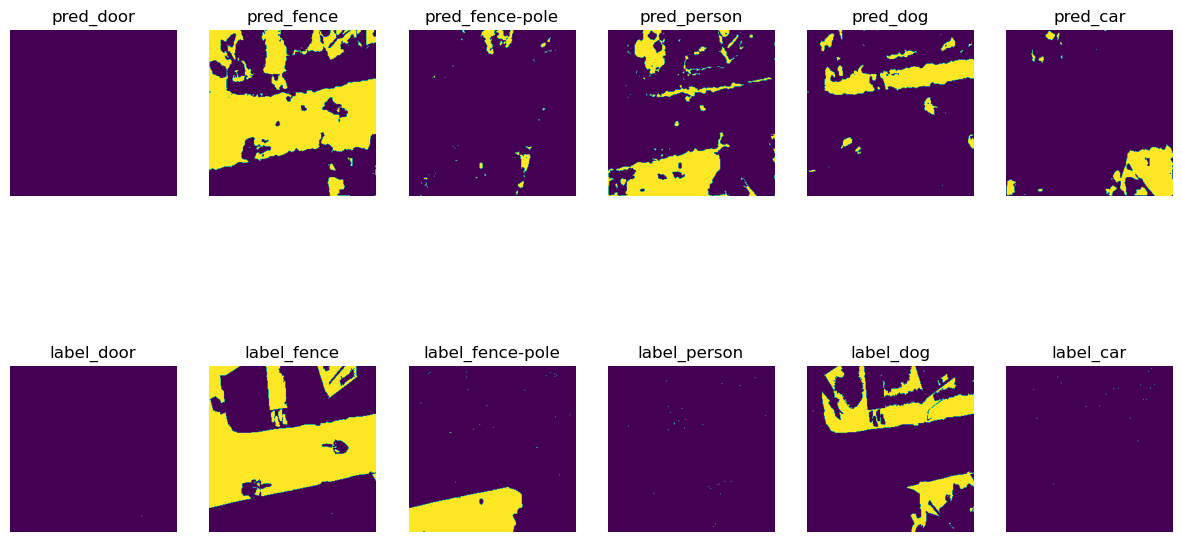

In [33]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for i in range(2):
    for j, cl in enumerate(classes[12:18]):
        if i == 0 and j < 6:
            ax[i, j].imshow(pred[0, :, :, j])
            ax[i, j].set_title(f"pred_{cl}")
            ax[i, j].axis("off")
        elif j < 6:
            ax[i, j].imshow(data["label"][0, j, :, :])    
            ax[i, j].set_title(f"label_{cl}")
            ax[i, j].axis("off")

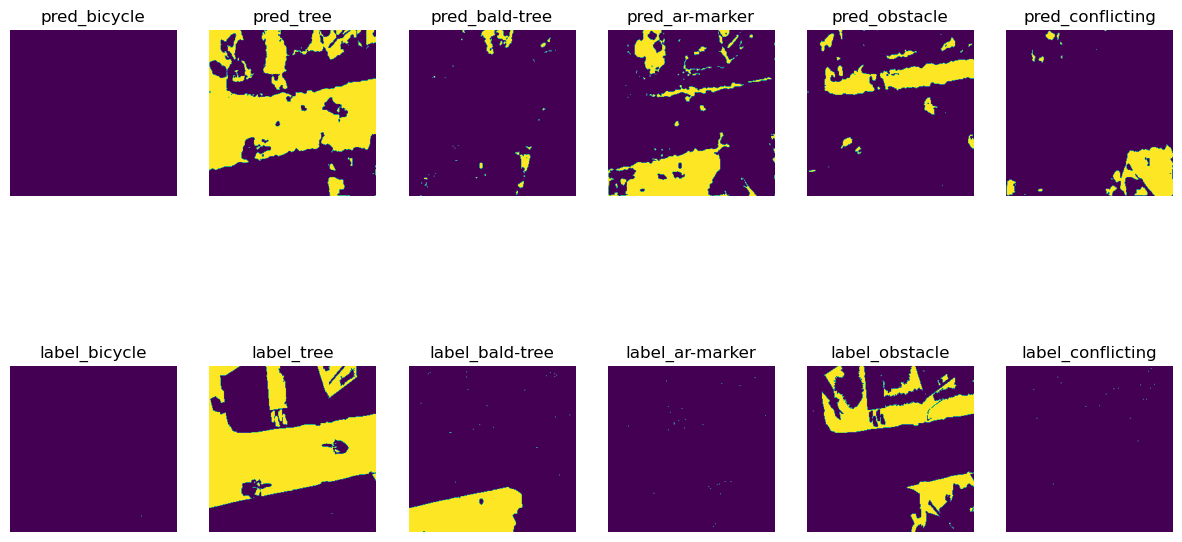

In [34]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for i in range(2):
    for j, cl in enumerate(classes[18:]):
        if i == 0 and j < 6:
            ax[i, j].imshow(pred[0, :, :, j])
            ax[i, j].set_title(f"pred_{cl}")
            ax[i, j].axis("off")
        elif j < 6:
            ax[i, j].imshow(data["label"][0, j, :, :])    
            ax[i, j].set_title(f"label_{cl}")
            ax[i, j].axis("off")

## Reference

[UNetを実装する](https://qiita.com/gensal/items/03e9a6d0f7081e77ba37)